The code below demonstrates KTMs. Recall this can be broken into 3 steps:
    
1. Generate distances, and projections to representative set
2. Convert discrete target trajectories into continuous functional trajectories
3. Train mixture density network to learn distributions over weights, 
which construct a mixture of stochastic processes.

Nice plot of sampled predicted trajectories below, at the bottom.


This is important to generate the necessary distances!

NB: to generate the Discrete Frechet distances, please install https://github.com/bguillouet/traj-dist. Cython may be required.
    

In [10]:
import numpy as np
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from keras import backend as K
import tensorflow as tf
from scipy import stats

from keras.engine.input_layer import Input
from keras.models import Sequential, Model
from keras.layers.core import Dropout
from keras.layers import concatenate,Dense
from keras.callbacks import History
from keras.models import model_from_json
from keras.regularizers import L1L2, l2, l1, l1_l2
from keras.initializers import Constant,RandomNormal
from keras import optimizers
from keras.backend import slice
from keras import optimizers
from keras.layers.advanced_activations import ELU
import matplotlib as mpl
import copy
import traj_dist.distance as traj_dist

import scipy
from numpy.linalg import inv

Software Versions:

In [11]:
print('np: '+str(np.__version__))
print('scipy: '+str(scipy.__version__))
print('tf: '+str(tf.VERSION))
print('mpl: '+str(mpl.__version__))

np: 1.16.4
scipy: 1.2.0
tf: 1.13.1
mpl: 2.2.4


The following code generates the distances between the trajectories. Only need to be run once.

In [ ]:
#This may take a while, but only need to run once!
#Only need to run once to generate distances between trajectories, save as FDLankershim_d.npy
ds=np.load("Lank_1_nn.npy",allow_pickle=True)
def GenDist(dp):
    counter=0
    difflists=np.empty((0,len(ds)))
    for i in dp:
        diffs=np.empty((0,1))
        for j in dp:
            diffc=np.array([traj_dist.discret_frechet(i[:,:2],j[:,:2])]).reshape((-1,1))
            diffs=np.concatenate((diffs,diffc),axis=0)
        difflists=np.concatenate((difflists,diffs.reshape(1,-1)),axis=0)
        counter+=1
        print(str(counter)+'/'+str(len(ds)))
    return difflists
dis=GenDist(ds)
np.save('FDLankershim_d.npy',dis)

The following code generates the functional trajectories and saves them. Only need to be run once.

In [2]:
# Only need to run once!
# Convert target trajectories in "Lank_2_nn.npy" to functional trajectories x(t) and y(t)
# stored in "x_weights_lanker_nn2.npy" and "y_weights_lanker_nn2.npy"
# Solving the ridge regression problems
ds=np.load("Lank_2_nn.npy",allow_pickle=True)
inducing_p=np.arange(0,26,5)
w_x_a=np.empty((0,len(inducing_p)))
for t_traj in ds:
    t=np.arange(0,len(t_traj))
    x=t_traj[:,0]-t_traj[0,0]
    y=t_traj[:,1]-t_traj[0,1]
    k_x=rbf_kernel(t[:25].reshape(-1, 1),inducing_p.reshape(-1, 1),gamma=0.05)
    k0=rbf_kernel(np.array([0]).reshape(-1, 1),inducing_p.reshape(-1, 1),gamma=0.05)
    mk0=np.dot(k0.T,k0)
    k_inv=inv(9e5*mk0+np.dot(k_x.T,k_x)+0.1*np.eye(len(k_x.T)))
    w_x_s=np.dot(np.dot(k_inv,k_x.T),y[:25].reshape(-1, 1))
    w_x_a=np.concatenate((w_x_a,w_x_s.reshape(1,-1)),axis=0)
np.save("y_weights_lanker_nn2.npy",w_x_a)
inducing_p=np.arange(0,26,5)
w_x_b=np.empty((0,len(inducing_p)))
for t_traj in ds:
    t=np.arange(0,len(t_traj))
    x=t_traj[:,0]-t_traj[0,0]
    y=t_traj[:,1]-t_traj[0,1]
    k_x=rbf_kernel(t[:25].reshape(-1, 1),inducing_p.reshape(-1, 1),gamma=0.05)
    k0=rbf_kernel(np.array([0]).reshape(-1, 1),inducing_p.reshape(-1, 1),gamma=0.05)
    mk0=np.dot(k0.T,k0)
    k_inv=inv(9e5*mk0+np.dot(k_x.T,k_x)+0.1*np.eye(len(k_x.T)))
    w_x_s=np.dot(np.dot(k_inv,k_x.T),x[:25].reshape(-1, 1))
    w_x_b=np.concatenate((w_x_b,w_x_s.reshape(1,-1)),axis=0)
np.save("x_weights_lanker_nn2.npy",w_x_b)

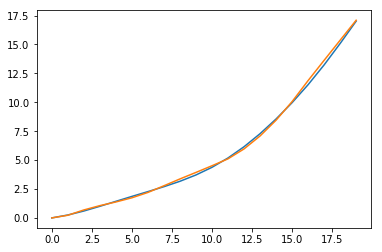

In [5]:
#Just a casual inspection of x(t) of the 2220th trajectory. This should work!
#Blue is our functional, orange line is interpolating to get x(t). We use our functional representation
t_traj=ds[2220]
x=t_traj[:,0]-t_traj[0,0]
y=t_traj[:,1]-t_traj[0,1]
t=np.arange(0,len(t_traj))
k_x=rbf_kernel(t[:25].reshape(-1, 1),inducing_p.reshape(-1, 1),gamma=0.05)
k_inv=inv(9e5*mk0+np.dot(k_x.T,k_x)+0.1*np.eye(len(k_x.T)))
w_x=np.dot(np.dot(k_inv,k_x.T),x[:25].reshape(-1, 1))
x_p=np.dot(k_x,w_x)
pl.plot(t[:20],x_p[:20],t[:20],x[:20])

The code below loads all the neccessary numpy files, and those generated above

In [3]:
#Load associated data
ds=np.load("Lank_1_nn.npy",allow_pickle=True)
dis=np.load("FDLankershim_d.npy")
weights_d=np.load("y_weights_lanker_nn2.npy")
weights_d_x=np.load("x_weights_lanker_nn2.npy")
ds2=np.load("Lank_2_nn.npy",allow_pickle=True)

In [ ]:
#Distance substitute kernel
gamma=0.005
kernelMat=np.exp(-gamma*np.power(dis,2))

Here we sample half of trajectories as representative.

In [4]:
l2_scores=np.linalg.norm(dis,axis=0)
np.flip(np.sort(l2_scores))
sorted_ind=np.flip(np.argsort(l2_scores))
sample_second=np.concatenate((np.arange(0,len(sorted_ind),2),np.arange(1,len(sorted_ind),2)),axis=0)
inds=sorted_ind[sample_second]
kernelMat=kernelMat[inds,:]
kernelMat=kernelMat[:,inds]
kernelMat=kernelMat[:,:int(kernelMat.shape[1]/2)] #Use half as representative trajectories
weights_d=weights_d[inds,:]
weights_d_x=weights_d_x[inds,:]
ds=ds[inds]
ds2=ds2[inds]

In [5]:
c=12 # Dimension of output
m=4 # number of distributions

# Various MDN loss functions. Based on implementation provided with Brando, 2017
def log_sum_exp(x, axis=None):
    """Log-sum-exp trick implementation"""
    x_max = K.max(x, axis=axis, keepdims=True)
    return K.log(K.sum(K.exp(x - x_max), 
                       axis=axis, keepdims=True))+x_max
def elu_modif(x, a=1.):
    return ELU(alpha=a)(x)+1.+1e-6

def mean_log_Gaussian_like_multi_ind(y_true, parameters):
    components = K.reshape(parameters,[-1, 2*c + 1, m])
    mu = components[:, :c, :]
    sigma = components[:, c:2*c, :]
    alpha = components[:, 2*c, :]
    alpha = K.softmax(K.clip(alpha,1e-8,1.))
    
    exponent = K.log(alpha) - .5 * float(c) * K.log(2 * np.pi) \
    - K.sum(K.log(sigma),axis=1) \
    - K.sum(((K.expand_dims(y_true,2) - mu)**2)/(2*(sigma)**2), axis=1)
    
    log_gauss = log_sum_exp(exponent, axis=1)
    res = - K.mean(log_gauss)
    return res

In [6]:
grand_ktm_like=[]
grand_cv_like=[]
grand_cdf_like=[]
grand_kdf_like=[]
grand_ktm_best=[]
grand_kdf_best=[]
#repeat 5 times
#We split the select 20% of the non-representing trajectories. 
#Half of the trajectories are representing trajectories, so 10% of total trajectories. 
for times in range(0,5):
    targetpointsg=np.concatenate((weights_d,weights_d_x),axis=1)
    train_size=int(kernelMat.shape[0]*0.9)
    rand_ind=np.random.permutation(int(kernelMat.shape[0]/2))
    obsXa=kernelMat[:int(kernelMat.shape[0]/2)]
    tarYa=targetpointsg[:int(kernelMat.shape[0]/2)]
    obsXb=kernelMat[int(kernelMat.shape[0]/2):]
    tarYb=targetpointsg[int(kernelMat.shape[0]/2):]
    ds_sha=ds[:int(kernelMat.shape[0]/2)]
    ds2_sha=ds2[:int(kernelMat.shape[0]/2)]
    ds_shb=ds[int(kernelMat.shape[0]/2):]
    ds2_shb=ds2[int(kernelMat.shape[0]/2):]    
    #shuffle
    obsXb=obsXb[rand_ind]
    tarYb=tarYb[rand_ind]
    ds_shb=ds_shb[rand_ind]
    ds2_shb=ds2_shb[rand_ind]   
    #reassemble    
    obsX=np.concatenate((obsXa,obsXb),axis=0)
    tarY=np.concatenate((tarYa,tarYb),axis=0)
    ds_sh=np.concatenate((ds_sha,ds_shb),axis=0)
    ds2_sh=np.concatenate((ds2_sha,ds2_shb),axis=0)       
    X_train=obsX[:train_size]
    X_test=obsX[train_size:]
    y_train=tarY[:train_size]
    y_test=tarY[train_size:]
    ds_sh_test=ds_sh[train_size:]
    ds2_sh_test=ds2_sh[train_size:]
    ######Neural Network Model Below############
    #with single hidden layer and 3 output layers which get concatenated#
    kernelNumber=kernelMat.shape[1]
    inputSize = kernelNumber
    inputlayer = Input(name='input', shape=(inputSize,))
    L0=Dense(5*c*m)(inputlayer)
    x1=Dense(output_dim=c*m)(L0)
    x2=Dense(output_dim=c*m,activation=elu_modif,kernel_regularizer=l2(0.05))(L0)
    x3=Dense(output_dim=m,activation='softmax',kernel_regularizer=l2(0.05))(L0)
    out=concatenate([x1,x2,x3])
    #Train up the Neural Network
    modelall = Model(inputs=inputlayer, outputs=out)
    modelall.compile(optimizer='rmsprop',loss=mean_log_Gaussian_like_multi_ind)
    modelall.fit(X_train,y_train[:,:],validation_data=(X_test, y_test),epochs=80,verbose = 1)

    e_ktm_like_list=[]
    e_cv_like_list=[]
    e_ktm_like_f_list=[]
    e_cv_like_f_list=[]
    e_ktm_best_list=[]
    e_ktm_best_f_list=[]
    c=12
    predy_t = modelall.predict(X_test.reshape((-1,kernelMat.shape[1]))).reshape([-1, 2*c + 1, m])
    mu_predall = predy_t[:, :c, :]
    sigma_predall = predy_t[:, c:2*c, :]
    alpha_predall = predy_t[:, 2*c, :]
    lengthpath=21
    t=np.arange(0,lengthpath)
    inducing_p=np.arange(0,26,5)
    k_t=rbf_kernel(t.reshape(-1, 1),inducing_p.reshape(-1, 1),gamma=0.05)
    for tn in range(0,len(X_test)):
        ds_t2=ds2_sh_test[tn]
        orig_t=ds_sh_test[tn]
        #Constant Velocity Model
        v_x=orig_t[-1,0]-orig_t[-2,0]
        v_y=orig_t[-1,1]-orig_t[-2,1]
        cv_x=orig_t[-1,0]+np.arange(0,lengthpath)*v_x
        cv_y=orig_t[-1,1]+np.arange(0,lengthpath)*v_y
        #Query our KTM-W model with trajectories that have sufficient lengths of time in target
        wy=np.dot(mu_predall[tn,:(c/2),:],alpha_predall[tn])
        wx=np.dot(mu_predall[tn,(c/2):,:],alpha_predall[tn])        
        x_pred=np.dot(k_t,wx)
        y_pred=np.dot(k_t,wy)
        end_x=orig_t[-1,0]
        end_y=orig_t[-1,1]
        x_pred+=end_x*np.ones(x_pred.shape)
        y_pred+=end_y*np.ones(y_pred.shape)
        if(len(ds_t2)>=lengthpath):
            if(np.linalg.norm(np.array([ds_t2[0,0]-ds_t2[lengthpath-1,0],ds_t2[1,1]-ds_t2[lengthpath-1,1]]))>20):
                e_ktm_n=np.linalg.norm(np.array([x_pred[-1]-ds_t2[lengthpath-1,0],y_pred[-1]-ds_t2[lengthpath-1,1]]))
                e_cv_n=np.linalg.norm(np.array([cv_x[-1]-ds_t2[lengthpath-1,0],cv_y[-1]-ds_t2[lengthpath-1,1]]))
                e_ktm_f=traj_dist.discret_frechet(np.concatenate((x_pred[:].reshape(-1,1),y_pred[:].reshape(-1,1)),axis=1),ds_t2[:20,:2])
                e_cv_f=traj_dist.discret_frechet(np.concatenate((cv_x[:].reshape(-1,1),cv_y[:].reshape(-1,1)),axis=1),ds_t2[:20,:2])
                e_ktm_like_list.append(e_ktm_n)
                e_cv_like_list.append(e_cv_n)
                e_ktm_like_f_list.append(e_ktm_f)
                e_cv_like_f_list.append(e_cv_f)
        #This corresponds to the KTM-C model
        wy=copy.deepcopy(mu_predall[tn,:(c/2),:])
        wx=copy.deepcopy(mu_predall[tn,(c/2):,:])
        x_pred=np.dot(k_t,wx)
        y_pred=np.dot(k_t,wy)
        end_x=orig_t[-1,0]
        end_y=orig_t[-1,1]
        x_pred+=end_x*np.ones(x_pred.shape)
        y_pred+=end_y*np.ones(y_pred.shape)
        if(len(ds_t2)>=lengthpath):
            if(np.linalg.norm(np.array([ds_t2[0,0]-ds_t2[lengthpath-1,0],ds_t2[1,1]-ds_t2[lengthpath-1,1]]))>20):
                e_ktm_n_l=[]
                e_ktm_df_l=[]
                for i in range(0,x_pred.shape[1]):
                    e_ktm_n_b=np.linalg.norm(np.array([x_pred[-1,i]-ds_t2[lengthpath-1,0],y_pred[-1,i]-ds_t2[lengthpath-1,1]]))
                    e_ktm_df_b=traj_dist.discret_frechet(np.concatenate((x_pred[:,i].reshape(-1,1),y_pred[:,i].reshape(-1,1)),axis=1),ds_t2[:lengthpath,:2])
                    e_ktm_n_l.append(e_ktm_n_b)
                    e_ktm_df_l.append(e_ktm_df_b)
                e_ktm_norm=np.min(np.array(e_ktm_n_l))
                e_ktm_dfr=np.min(np.array(e_ktm_df_l))
                e_ktm_best_list.append(e_ktm_norm)
                e_ktm_best_f_list.append(e_ktm_dfr)
    cur_like_ktm=np.average(np.array(e_ktm_like_list))
    cur_like_cv=np.average(np.array(e_cv_like_list))
    cur_like_kdf_df=np.average(np.array(e_ktm_like_f_list))
    cur_like_cdf_df=np.average(np.array(e_cv_like_f_list))
    cur_b_ktm_norm=np.average(np.array(e_ktm_best_list))
    cur_b_ktm_dfr=np.average(np.array(e_ktm_best_f_list))

    print("N-KTM: "+str(cur_like_ktm))
    print("N-CV: "+str(cur_like_cv))
    print("F-KTM: "+str(cur_like_kdf_df))
    print("F-CV: "+str(cur_like_cdf_df))
    print("BestN-KTM: "+str(cur_b_ktm_norm))
    print("BestF-KTM: "+str(cur_b_ktm_dfr))
    
    grand_ktm_like.append(cur_like_ktm)
    grand_cv_like.append(cur_like_cv)
    grand_kdf_like.append(cur_like_kdf_df)
    grand_cdf_like.append(cur_like_cdf_df)
    grand_ktm_best.append(cur_b_ktm_norm)
    grand_kdf_best.append(cur_b_ktm_dfr)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=48)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=48, activation=<function ..., kernel_regularizer=<keras.reg...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=4, activation="softmax", kernel_regularizer=<keras.reg...)`


Train on 5922 samples, validate on 658 samples
Epoch 1/80
5922/5922 [==============================] - 1s 232us/step - loss: 90.3516 - val_loss: 41.1424
Epoch 2/80
5922/5922 [==============================] - 1s 164us/step - loss: 36.6836 - val_loss: 36.2835
Epoch 3/80
5922/5922 [==============================] - 1s 167us/step - loss: 32.4847 - val_loss: 32.4965
Epoch 4/80
5922/5922 [==============================] - 1s 166us/step - loss: 30.2644 - val_loss: 31.2406
Epoch 5/80
5922/5922 [==============================] - 1s 167us/step - loss: 28.7222 - val_loss: 39.8092
Epoch 6/80
5922/5922 [==============================] - 1s 167us/step - loss: 27.7431 - val_loss: 27.9214
Epoch 7/80
5922/5922 [==============================] - 1s 170us/step - loss: 26.8523 - val_loss: 28.0565
Epoch 8/80
5922/5922 [==============================] - 1s 174us/step - loss: 26.3193 - val_loss: 27.1759
Epoch 9/80
5922/5922 [==============================] - 1s 176us/step - loss: 25.7520 - val_loss: 25.9925

Epoch 72/80
5922/5922 [==============================] - 1s 175us/step - loss: 19.4607 - val_loss: 21.6218
Epoch 73/80
5922/5922 [==============================] - 1s 175us/step - loss: 19.4073 - val_loss: 21.6370
Epoch 74/80
5922/5922 [==============================] - 1s 177us/step - loss: 19.3591 - val_loss: 20.9393
Epoch 75/80
5922/5922 [==============================] - 1s 176us/step - loss: 19.4831 - val_loss: 20.8272
Epoch 76/80
5922/5922 [==============================] - 1s 179us/step - loss: 19.3725 - val_loss: 20.5280
Epoch 77/80
5922/5922 [==============================] - 1s 180us/step - loss: 19.4383 - val_loss: 21.3524
Epoch 78/80
5922/5922 [==============================] - 1s 180us/step - loss: 19.4270 - val_loss: 21.3261
Epoch 79/80
5922/5922 [==============================] - 1s 179us/step - loss: 19.3002 - val_loss: 20.0738
Epoch 80/80
5922/5922 [==============================] - 1s 179us/step - loss: 19.3885 - val_loss: 20.5664
N-KTM: 11.471108090056864
N-CV: 11.65

Epoch 61/80
5922/5922 [==============================] - 1s 180us/step - loss: 20.5101 - val_loss: 22.4487
Epoch 62/80
5922/5922 [==============================] - 1s 186us/step - loss: 20.5916 - val_loss: 23.8002
Epoch 63/80
5922/5922 [==============================] - 1s 185us/step - loss: 20.5351 - val_loss: 22.3350
Epoch 64/80
5922/5922 [==============================] - 1s 179us/step - loss: 20.4870 - val_loss: 22.6366
Epoch 65/80
5922/5922 [==============================] - 1s 191us/step - loss: 20.3772 - val_loss: 21.9029
Epoch 66/80
5922/5922 [==============================] - 1s 211us/step - loss: 20.4056 - val_loss: 23.3827
Epoch 67/80
5922/5922 [==============================] - 1s 209us/step - loss: 20.4089 - val_loss: 21.9440
Epoch 68/80
5922/5922 [==============================] - 1s 198us/step - loss: 20.3691 - val_loss: 21.8612
Epoch 69/80
5922/5922 [==============================] - 1s 191us/step - loss: 20.3770 - val_loss: 21.6362
Epoch 70/80
5922/5922 [==============

In [7]:
grand_ktm_like_np=np.array(grand_ktm_like)
grand_cv_like_np=np.array(grand_cv_like)
grand_kdf_like_np=np.array(grand_kdf_like)
grand_cdf_like_np=np.array(grand_cdf_like)
grand_ktm_best_np=np.array(grand_ktm_best)
grand_kdf_best_np=np.array(grand_kdf_best)

View quantitative results:

In [17]:
print("Mean ED for KTM-W model:"+str(np.mean(grand_ktm_like_np)))
print("Standard deviation ED for KTM-W model:"+str(np.std(grand_ktm_like_np)))

print("Mean ED for CV model:"+str(np.mean(grand_cv_like_np)))
print("Standard deviation ED for CV model:"+str(np.std(grand_cv_like_np)))

print("Mean DF for KTM-W model:"+str(np.mean(grand_kdf_like_np)))
print("Standard deviation DF for KTM-W model:"+str(np.std(grand_kdf_like_np)))

print("Mean DF for CV model:"+str(np.mean(grand_cdf_like_np)))
print("Standard DF deviation for CV model:"+str(np.std(grand_cdf_like_np)))

print("Mean ED for KTM-W model:"+str(np.mean(grand_ktm_best_np)))
print("Standard deviation ED for KTM-C model:"+str(np.std(grand_ktm_best_np)))

print("Mean DF for KTM-W model:"+str(np.mean(grand_kdf_best_np)))
print("Standard deviation DF for KTM-C model:"+str(np.std(grand_kdf_best_np)))

Mean ED for KTM-W model:11.46804888108788
Standard deviation ED for KTM-W model:0.18713873652677956
Mean ED for KTM-W model:11.30736660509715
Standard deviation ED for KTM-W model:0.1985275456472206
Mean DF for KTM-W model:11.51559879464224
Standard deviation DF for KTM-W model:0.46189737704618383
Mean DF for KTM-W model:10.725410613778651
Standard DF deviation for KTM-W model:0.21670224042476247
Mean ED for KTM-W model:5.770425475661992
Standard deviation ED for KTM-W model:0.3477125578186743
Mean DF for KTM-W model:6.31470485691571
Standard deviation DF for KTM-W model:0.27126383565571477


Now lets have a look at some trajectories! Trajectories numbered 5922 and above are test set trajectories. The indices change everytime there is a train/test split. Lets get 300 samples from the mixture, plot out x(t), y(t). Then, plot the trajectories with the ground truth!

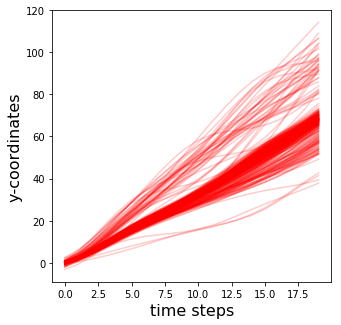

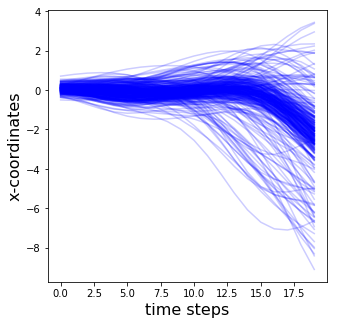

In [51]:
c=12
Traj_n=5922 #The trajectory we want to query
realisations=300 # The number of realisations we want to sample from our mixture
ds_n=Traj_n
ds_t=ds[ds_n]
ds_t2=ds2[ds_n]
orig_t=ds_t
predy_t = modelall.predict(kernelMat[Traj_n].reshape((1,-1))).reshape([-1, 2*c + 1, m])
mu_predall = predy_t[:, :c, :]
sigma_predall = predy_t[:, c:2*c, :]
alpha_predall = predy_t[:, 2*c, :]
t=np.arange(0,20)
inducing_p=np.arange(0,26,5)
w_i_x=mu_predall[0,(c/2):,np.argmax(alpha_predall[0])]
k_t=rbf_kernel(t.reshape(-1, 1),inducing_p.reshape(-1, 1),gamma=0.05)
x_pred=np.dot(k_t,w_i_x)
wy_list=[]
wx_list=[]
for j in range(0, realisations):
    best=0
    cumulativeVal=0
    cumulativeValUpper=0
    randNum=np.random.uniform(low=0.0, high=1.0)
    for i in range(0,len(alpha_predall[0])):
        cumulativeValUpper+=alpha_predall[0][i]
        if((randNum>cumulativeVal)and (randNum<=cumulativeValUpper)):
            best=i
        cumulativeVal+=alpha_predall[0][i]    
    stdevListy=sigma_predall[0,:(c/2),best]
    w_i_y=copy.deepcopy(mu_predall[0,:(c/2),best])
    for i in range(0,len(w_i_y)):    
        stdev=stdevListy[i]
        sample_change=np.random.normal(0, stdev)
        w_i_y[i]+=sample_change
    wy_list.append(w_i_y)
    stdevListx=sigma_predall[0,(c/2):,best]
    w_i_x=copy.deepcopy(mu_predall[0,(c/2):,best])
    for i in range(0,len(w_i_y)):    
        stdev=stdevListx[i]
        sample_change=np.random.normal(0, stdev)
        w_i_x[i]+=sample_change
    wx_list.append(w_i_x)
wy_list_np=np.array(wy_list)
wx_list_np=np.array(wx_list)
pl.figure(figsize=(5,5))
for w in wy_list_np:
    y_pred=np.dot(k_t,w)
    pl.plot(t,y_pred,'r-',alpha=0.2)
pl.xlabel("time steps", fontsize=16)
pl.ylabel("y-coordinates", fontsize=16)
pl.show()
pl.figure(figsize=(5,5))
for w in wx_list_np:
    x_pred=np.dot(k_t,w)
    pl.plot(t,x_pred,'b-',alpha=0.2)
pl.xlabel("time steps", fontsize=16)
pl.ylabel("x-coordinates", fontsize=16)
pl.show()

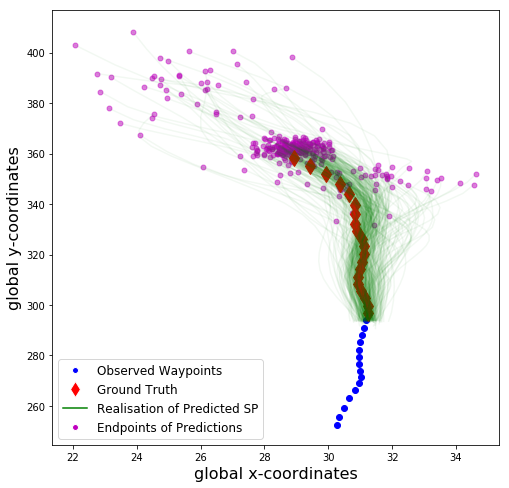

In [52]:
pl.figure(figsize=(8,8))
a=pl.plot(orig_t[:,0],orig_t[:,1],'b.',markersize=12)
b=pl.plot(ds_t2[:20,0],ds_t2[:20,1],'rd',markersize=12)
#pl.axis([-100, 100, 250, 500]) 
for i in range(0,len(wx_list_np)):
    x_pred=np.dot(k_t,wx_list_np[i])
    y_pred=np.dot(k_t,wy_list_np[i])
    end_x=orig_t[-1,0]
    end_y=orig_t[-1,1]
    x_pred+=end_x*np.ones(x_pred.shape)
    y_pred+=end_y*np.ones(y_pred.shape)
    c=pl.plot(x_pred,y_pred,'g-',alpha=0.05)
    d=pl.scatter(x_pred[-1],y_pred[-1],alpha=0.5,s=24, c="m")

blue = mpl.lines.Line2D([0], [0], marker='.', color='w',
                          markerfacecolor='b', markersize=12, label='Observed Waypoints')
red = mpl.lines.Line2D([0], [0], marker='d', color='w',
                          markerfacecolor='r', markersize=12, label='Ground Truth')
green = mpl.lines.Line2D([0], [0], color='g',
                          markerfacecolor='g', label='Realisation of Predicted SP',alpha=1)
magenta = mpl.lines.Line2D([0], [0], marker='.', color='w',
                          markerfacecolor='m', markersize=12, label='Endpoints of Predictions')
pl.legend(handles=[blue,red,green,magenta],prop={'size': 12})
pl.xlabel("global x-coordinates", fontsize=16)
pl.ylabel("global y-coordinates", fontsize=16)
pl.show()    